# R - Notebook for exploratory analysis and plots

In [5]:
#install.packages("devtools")
#devtools::install_github("jayjacobs/verisr")
#devtools::install_github("onlyphantom/verisr2")
#install.packages("dplyr", "magrittr", "verisr", "verisr2", "DataCombine", "RColorBrewer", "gridExtra",
#                 "grid", "data.table", "ggplot2", "repr", "rworldmap")
options(warn=-1)
library(magrittr)
library(verisr)
library(DataCombine)
library(RColorBrewer)
library(gridExtra)
library(grid)
library(data.table)
library(ggplot2)
source("funs.r")
library(repr)
library(rworldmap)
library(verisr2)
#library(tidyverse)

## Data

In [7]:
# read from json
#schema.loc <- "./GIT/VCDB/vcdb-merged.json"
#vcdb.dir<-"./GIT/VCDB/data/json/validated"
#vcdb <- verisr::json2veris(dir=vcdb.dir, schema=schema.loc)

#read from csv
vcdb.clean.dir <- "./vcdb_clean.csv"
vcdb <- fread(vcdb.clean.dir)
vcdb_p<- cbind(vcdb, getpattern(vcdb))
ready <- fread("./ready.csv")

# Interesting Generic Statistics

## Timelines
### Distribution of incidents over the years

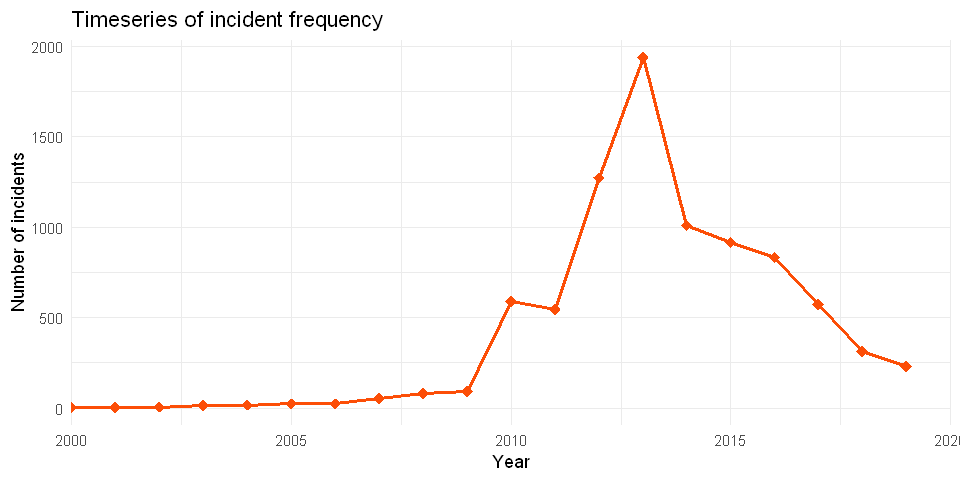

In [8]:
options(repr.plot.width=8, repr.plot.height=4)
t <- getenum(vcdb, "timeline.incident.year")
#t$enum <- as.year(t$enum)
t$enum <- as.numeric(as.character(t$enum))
t <- t[order(t$enum),]
ggplot(t, aes(x=enum, y=x)) + geom_point(pch=18, size=3, color="#FC4E07") +
  geom_line(size=1, color="#FC4E07") + 
  labs(y = "Number of incidents", x = "Year", title=
         "Timeseries of incident frequency") + 
  theme_minimal() + scale_x_continuous(expand=c(0,0), limits=c(2000, 2020))

2013 spike! However is that reflected to number of breaches and records lost?

### Breach vs incident through the years:
(Breach means that information was disclosed)

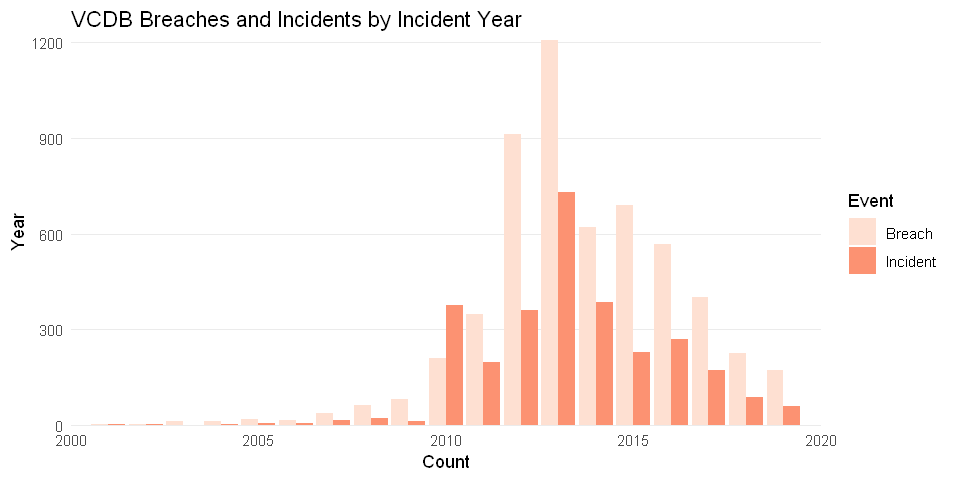

In [9]:
vcdb %>%
    dplyr::group_by(attribute.confidentiality.data_disclosure.Yes) %>%
    dplyr::count(timeline.incident.year) %>%
    dplyr::ungroup() %>%
    dplyr::rename(Event = attribute.confidentiality.data_disclosure.Yes) %>%
    dplyr::mutate(Event = ifelse(Event, "Breach", "Incident")) %>%
    ggplot() +geom_bar(aes(x=timeline.incident.year, y=n, group=Event, fill=Event), 
                     stat="identity", position="dodge") +
    labs(title="VCDB Breaches and Incidents by Incident Year", x="Count", y="Year") +
    scale_x_continuous(expand=c(0,0), limits=c(2000, 2020)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_brewer(palette=14) + theme_minimal() +
    theme(
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank()
    )

Yes it is reflected to number of breaches as well. However some breaches might lead to million records lost some others to a minor number of them. For example in 2013 Yahoo hack accounted for one billion records lost. The next closest incident (Target data breach) resulted in over 110 million records lost 

### Records lost over the years

Let's investigate the number of lost records by year

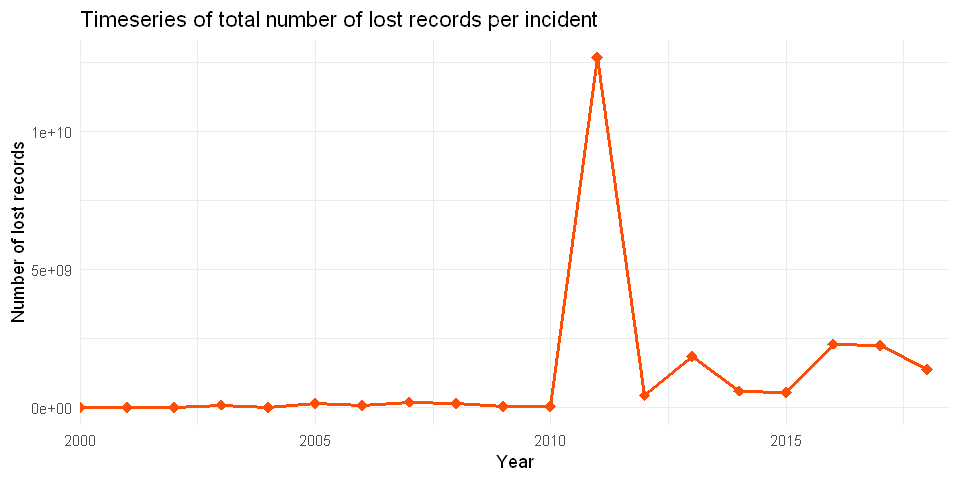

In [10]:
t <- ready[,(lost.records=sum(attribute.confidentiality.data_total)),
           by=.(timeline.incident.year)]
t <- t[order(t$timeline.incident.year),]
ggplot(t, aes(x=timeline.incident.year, y=V1)) +
  geom_point(pch=18, size=3, color="#FC4E07") +
  geom_line(size=1, color="#FC4E07") + 
  labs(y = "Number of lost records", x = "Year", title=
         "Timeseries of total number of lost records per incident") + 
  theme_minimal() + scale_x_continuous(expand=c(0,0), limits=c(2000, 2018.5))

We see that 2011 was the worst year in terms of lost records despite the fact that 2013 was top in terms of incident frequency. Obviously the average number of records breached per incident was much higher in 2011. Proof:

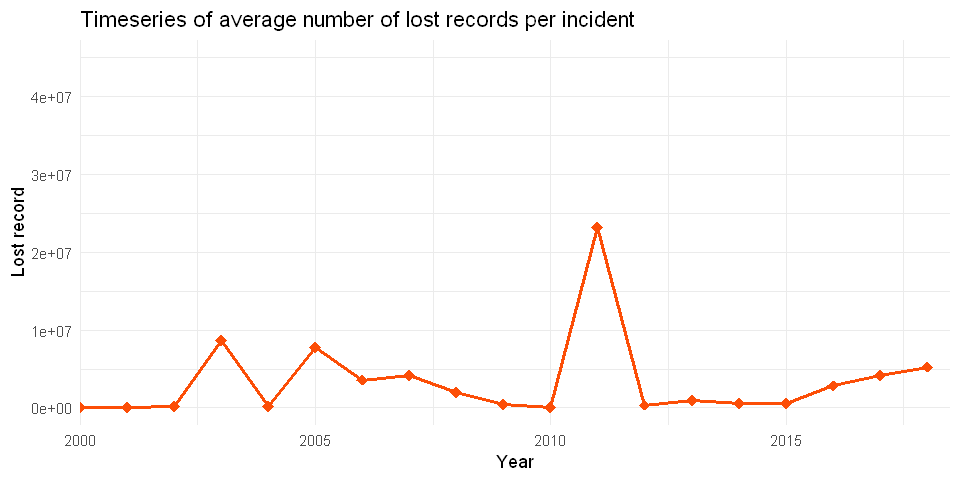

In [11]:
t <- ready[,.(lost.records=mean(attribute.confidentiality.data_total)),
           by=.(timeline.incident.year)]
t <- t[order(t$timeline.incident.year),]

ggplot(t, aes(x=timeline.incident.year, y=lost.records)) +
  geom_point(pch=18, size=3, color="#FC4E07") +
  geom_line(size=1, color="#FC4E07") + 
  labs(y = "Lost record", x = "Year", title=
         "Timeseries of average number of lost records per incident") + 
  theme_minimal() + scale_x_continuous(expand=c(0,0), limits=c(2000, 2018.5))

## External Variety

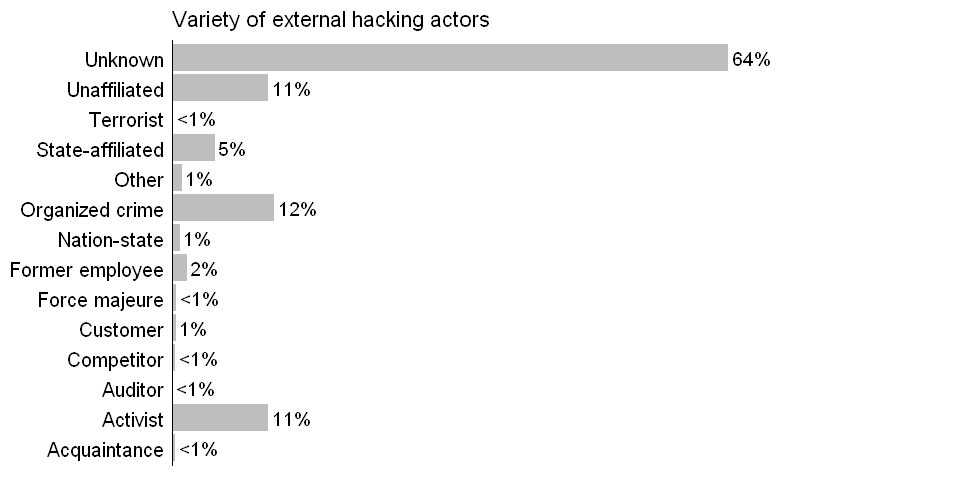

In [12]:
ext.variety <- getenum(vcdb, "actor.external.variety")
simplebar(ext.variety, "Variety of external hacking actors", "grey")


## Attack pattern - Actor category

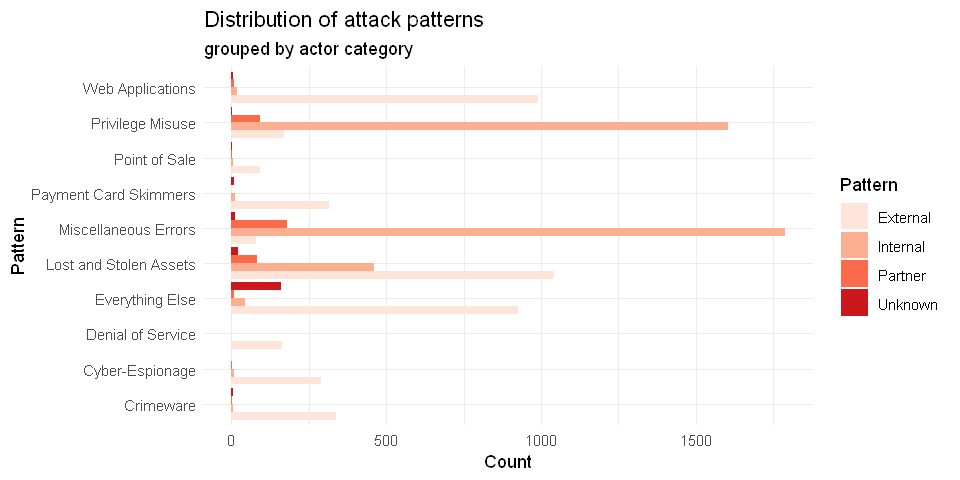

In [13]:
a <- getenum_df(vcdb_p, c("actor", "pattern"))
gg <- ggplot(a, aes(x=pattern, x, fill=actor))
gg <- gg + geom_bar(stat="identity", position="dodge") + 
    guides(fill=guide_legend(title="Pattern"))
gg <- gg + labs(title="Distribution of attack patterns", 
                subtitle = "grouped by actor category", 
                x="Pattern", y="Count")
gg2 <- gg  + theme_minimal() + scale_fill_brewer(palette=14) +
     coord_flip()
print(gg2)

Errors -> Mostly from internal actors (rational conclusion: errors at work, spam, fishing, etc..)


## Action - Asset

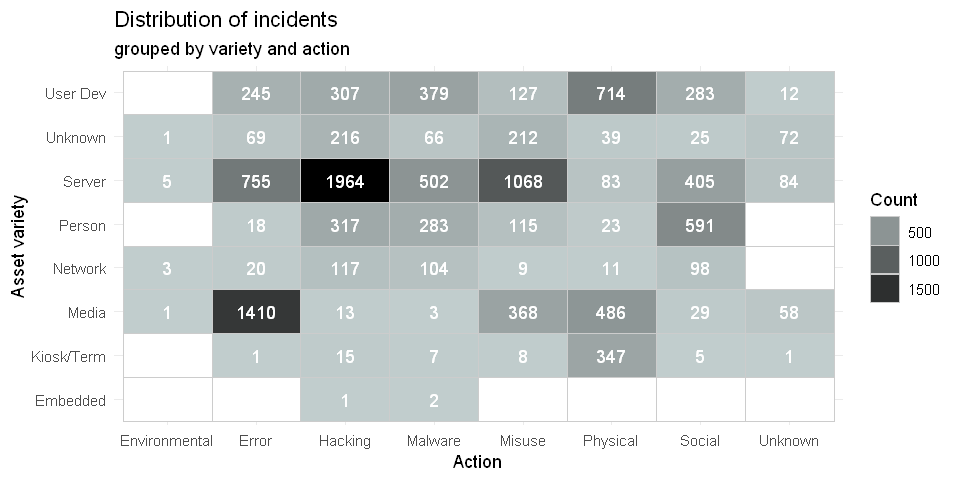

In [14]:
enum2grid(vcdb, c("action", "asset.variety")) + 
  guides(fill=guide_legend(title="Count")) +
  theme_minimal() + labs(title="Distribution of incidents",
  subtitle="grouped by variety and action", y="Asset variety", x="Action")

## Action - Organisation size

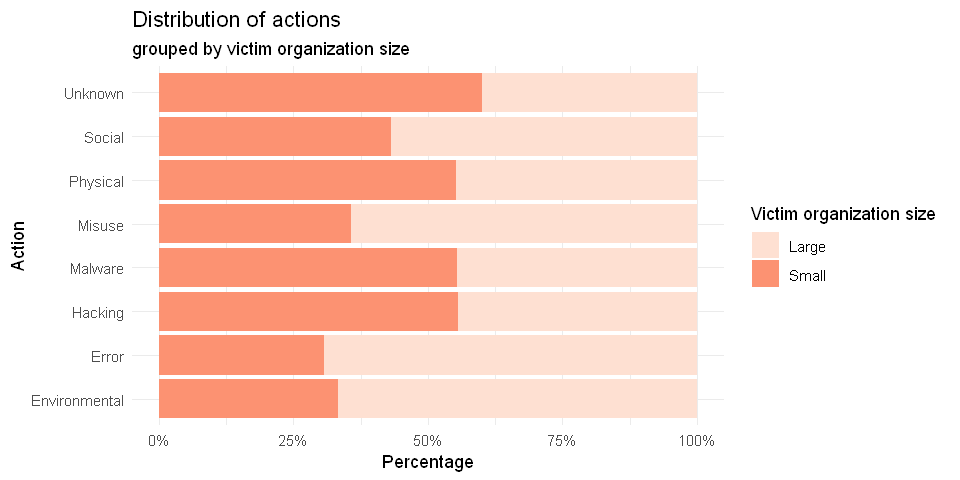

In [15]:
a <- getenum_df(vcdb, c("action", "victim.orgsize"))
gg <- ggplot(a, aes(x=action, y=x, fill=victim.orgsize))
gg <- gg + geom_bar(stat="identity", position="fill") + 
    guides(fill=guide_legend(title="Victim organization size"))
gg <- gg + labs(title="Distribution of actions", 
                subtitle = "grouped by victim organization size", 
                x="Action", y="Percentage")
gg <- gg  + theme_minimal() + scale_fill_brewer(palette=14) +
    scale_y_continuous(labels=scales::percent) + coord_flip()
print(gg)

## Victim countries

138 codes from your data successfully matched countries in the map
2 codes from your data failed to match with a country code in the map
103 codes from the map weren't represented in your data


You asked for 7 quantiles, only 4 could be created in quantiles classification


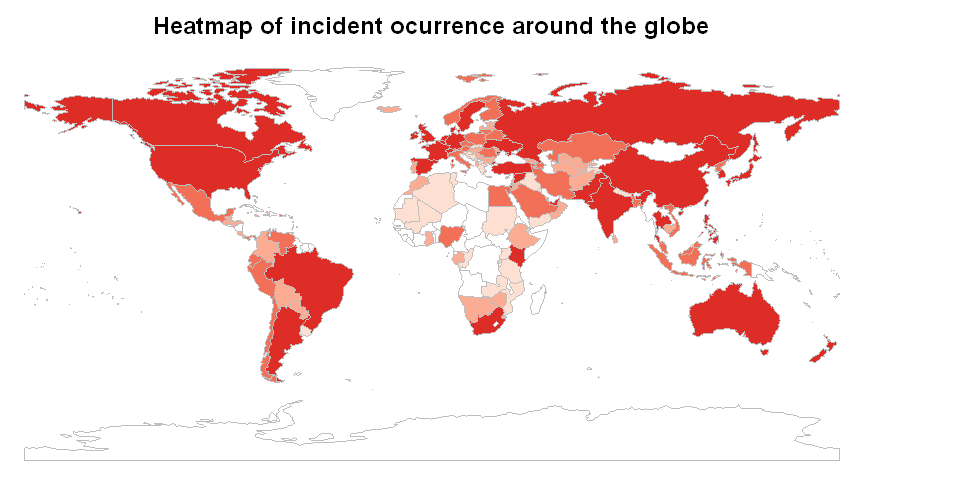

In [16]:
a <- getenum_df(vcdb, c("victim.country"))
a <- a[c("enum","x")]
names(a) <- c("enum", "Incident intensity")
mapped_data <- joinCountryData2Map(a, joinCode = "ISO2", 
    nameJoinColumn = "enum")
par(mai=c(0,0.2,0.4,1),xaxs="i",yaxs="i")
mapCountryData(mapped_data, nameColumnToPlot = "Incident intensity",
               mapTitle = "Heatmap of incident ocurrence around the globe",
               colourPalette= brewer.pal(n = -10, name = "Reds"), 
               addLegend = F)

Comments... Further analysis through FP-Growth
Code: association_rules.py
Frequent itemsets in usual_suspects.csv. Some conclusions... Already found that:
US<->US, UK<->UK, North Korea(attacker) -> South Korea (Victim) (18 incidents)
Mention 1 or 2 more!

# Victim industry specific Analysis

## Initial Distribution Barplot

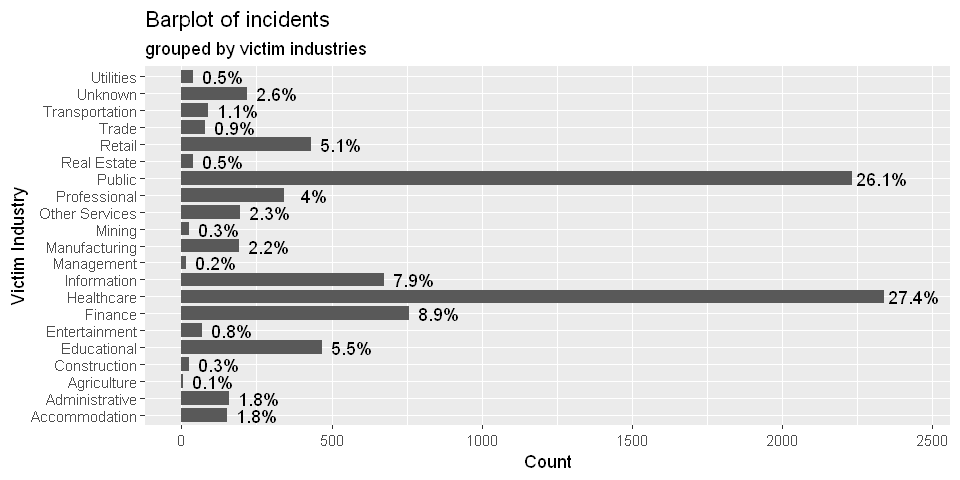

In [17]:
# We add pattern columns
ind.name <- getenum(vcdb, c("victim.industry.name"))
ggplot(ind.name, aes(x = enum, y=x)) + geom_bar(width=0.8, stat="identity") + geom_text(aes(label=paste(as.character(round(x/n[1]*100,1)), "%", sep="")), nudge_y=100, size=3.8) +
labs(title="Barplot of incidents", subtitle= "grouped by victim industries",
     x="Victim Industry", y="Count") + coord_flip()

### Victim industry compact barplots (aggregated smaller industries)

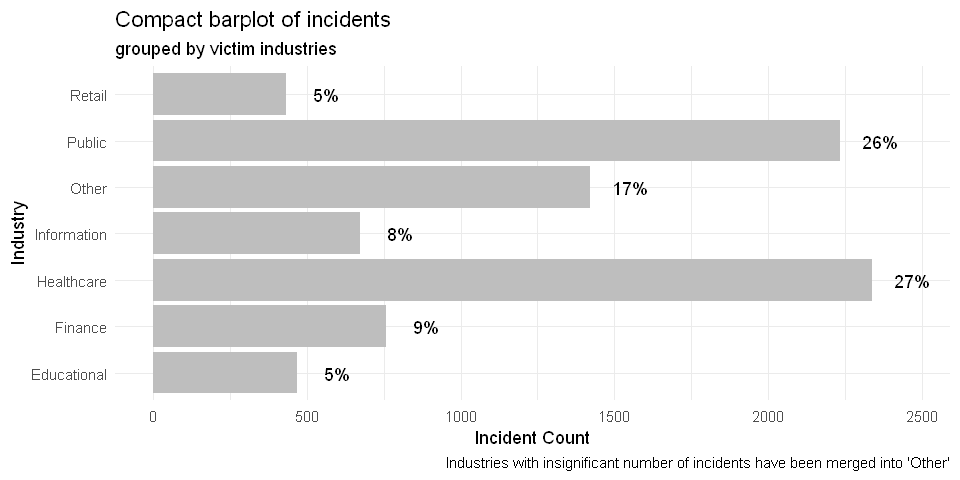

In [18]:
# We add pattern columns
b <- getenum(vcdb, c("victim.industry2"))
#convert NAICS to Name
n1 <- b$n[1]
b$enum <- mapping_compact(b$enum)
b <- aggregate(.~enum, b, sum)
b$n <- n1

gg <- ggplot(b, aes(x=enum, y=x))
gg <- gg + geom_bar(stat="identity", fill="grey")
gg <- gg + labs(x="Industry", y="Incident Count",
  title = "Compact barplot of incidents",
  subtitle="grouped by victim industries",
  caption="Industries with insignificant number of incidents have been merged into 'Other'") +
  geom_text(aes(label=paste(as.character(round(x/n[1]*100,0)), "%", sep="")), 
    nudge_y=130, size=3.8) + coord_flip() + theme_minimal()
print(gg) 

### Distribution of incidents over the years by industry

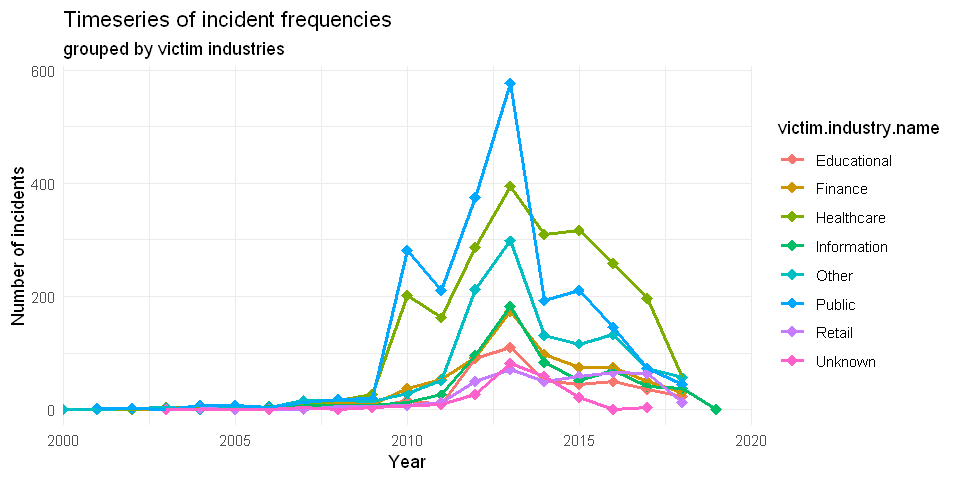

In [19]:
t <- ready %>%
    dplyr::group_by(victim.industry.name) %>%
    dplyr::count(timeline.incident.year) %>%
    dplyr::ungroup() %>% data.table()
t$victim.industry.name <- mapping_new(t$victim.industry.name)
t <- aggregate(.~victim.industry.name+timeline.incident.year, t, sum)

ggplot(t, aes(x=timeline.incident.year, y=n)) +
  geom_point(pch=18, size=3, aes(color=victim.industry.name)) +
  geom_line(size=1, aes(color=victim.industry.name)) + 
  labs(y = "Number of incidents", x = "Year",
       title="Timeseries of incident frequencies",
       subtitle="grouped by victim industries") + 
  theme_minimal() + scale_x_continuous(expand=c(0,0), limits=c(2000, 2020))

2013 top year of incidents! Health care did not fall as much as the others after that

## Victim industry - Asset Variety

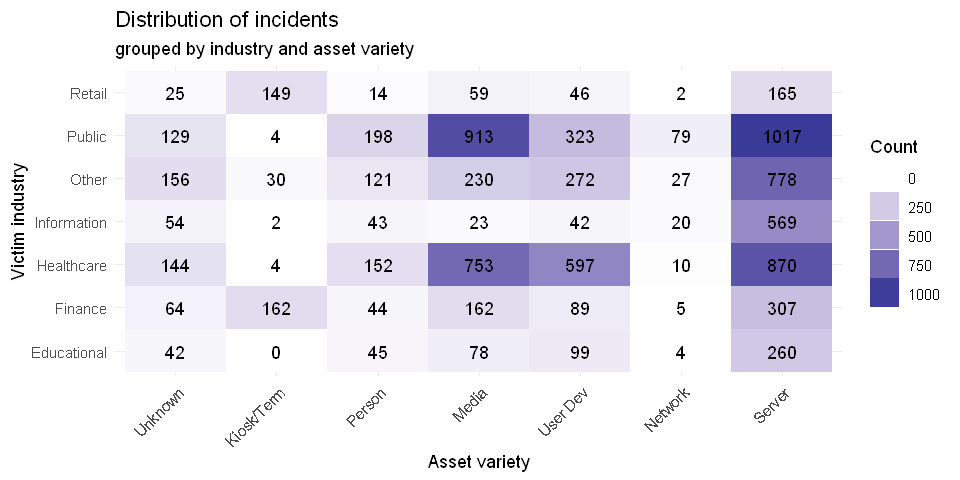

In [20]:
b <- getenum(vcdb, c("victim.industry2", "asset.variety"))
#convert NAICS to Name
n1 <- b$n[1]
b$enum <- mapping_compact(b$enum)
b <- aggregate(.~enum1+enum, b, sum)
b$n <- n1
b <-b[!(b$enum=="NA" | b$enum1=="NA"),] 
ggplot(b) + geom_tile(aes(x=enum, y=enum1, fill=x)) +
  geom_text(aes(x=enum, y=enum1, label=x)) +
  scale_fill_gradient2() + coord_flip() +
  theme_minimal() + labs(title="Distribution of incidents",
                         subtitle="grouped by industry and asset variety", 
                         y="Asset variety", x="Victim industry")+
  guides(fill=guide_legend(title="Count")) +
  theme_minimal() +
  theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45)) 

## Victim industry - Action

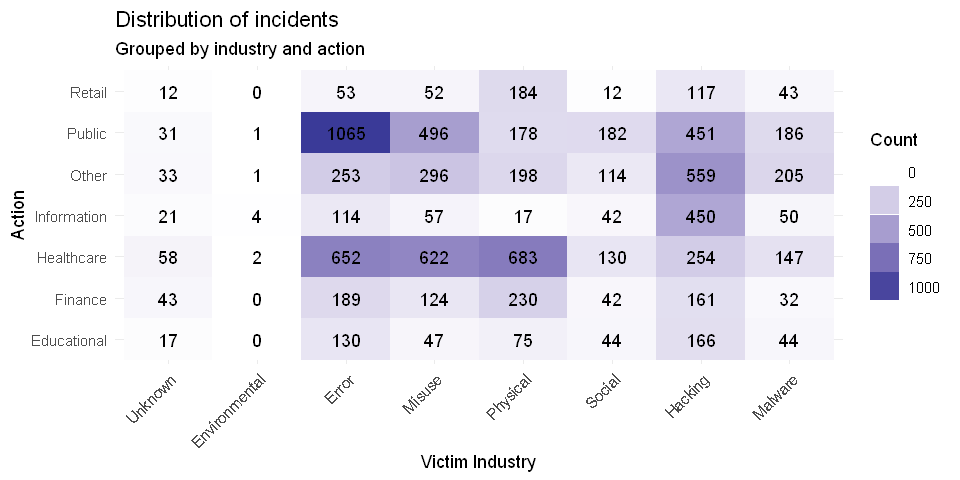

In [21]:
b <- getenum(vcdb, c("victim.industry2", "action"))
n1 <- b$n[1]
b$enum <- mapping_compact(b$enum)
b <- aggregate(.~enum1+enum, b, sum)
b$n <- n1
b <-b[!(b$enum=="NA" | b$enum1=="NA"),] 

ggplot(b) + geom_tile(aes(x=enum, y=enum1, fill=x)) +
  geom_text(aes(x=enum, y=enum1, label=x)) +
  scale_fill_gradient2() + coord_flip() +
  theme_minimal() + labs(title="Distribution of incidents",
                         subtitle="Grouped by industry and action", 
                         y="Victim Industry", x="Action")+
  guides(fill=guide_legend(title="Count")) +
  theme_minimal() +
  theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45)) 
#grid.arrange(arrangeGrob(p1+theme(legend.position="none"),
#p2 + theme(legend.position="none"), nrow=1), top=textGrob("Distribution of incidents"))

## Victim industry - Motive

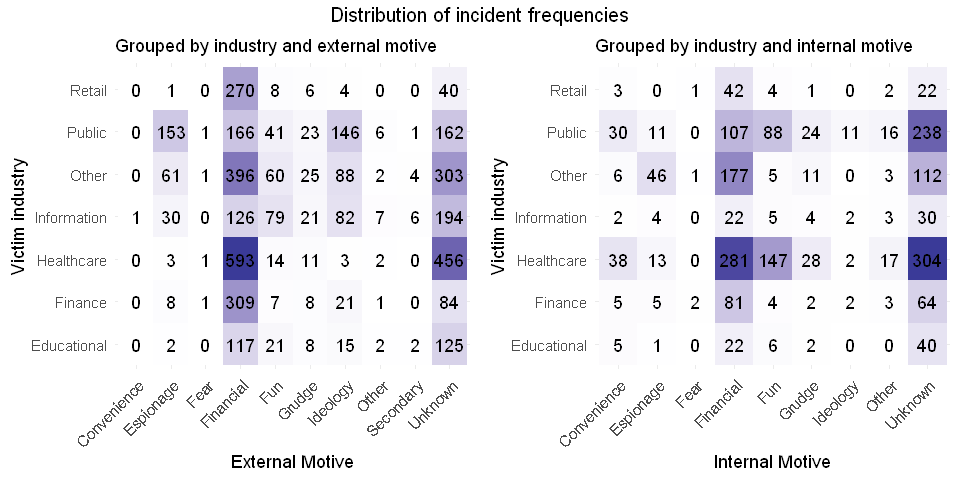

In [22]:
i<- getenum(vcdb, c("victim.industry2", "actor.internal.motive"))
#convert NAICS to Name
n1 <- i$n[1]
i$enum <- mapping_compact(i$enum)
i <- aggregate(.~enum1+enum, i, sum)
i$n <- n1
i <-i[!(i$enum=="NA" | i$enum1=="NA"),] 

e<- getenum(vcdb, c("victim.industry2", "actor.external.motive"))
#convert NAICS to Name
n1 <- e$n[1]
e$enum <- mapping_compact(e$enum)
e <- aggregate(.~enum1+enum, e, sum)
e$n <- n1
e <-e[!(e$enum=="NA" | e$enum1=="NA"),] 

p1 <- ggplot(e) + geom_tile(aes(x=enum, y=enum1, fill=x)) +
  geom_text(aes(x=enum, y=enum1, label=x)) +
  scale_fill_gradient2() + coord_flip() +
  theme_minimal() + labs(subtitle="Grouped by industry and external motive", 
                         y="External Motive", x="Victim industry")+
  theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45)) 

p2 <-  ggplot(i) + geom_tile(aes(x=enum, y=enum1, fill=x)) +
  geom_text(aes(x=enum, y=enum1, label=x)) +
  scale_fill_gradient2() + coord_flip() +
  theme_minimal() + labs(subtitle="Grouped by industry and internal motive", 
                         y="Internal Motive", x="Victim industry")+
  theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45)) 
grid.arrange(arrangeGrob(p1+theme(legend.position="none"),
  p2 + theme(legend.position="none"), nrow=1), 
  top=textGrob("Distribution of incident frequencies"))


Internal motive -> Fun!!

## Victim industry - Attack pattern

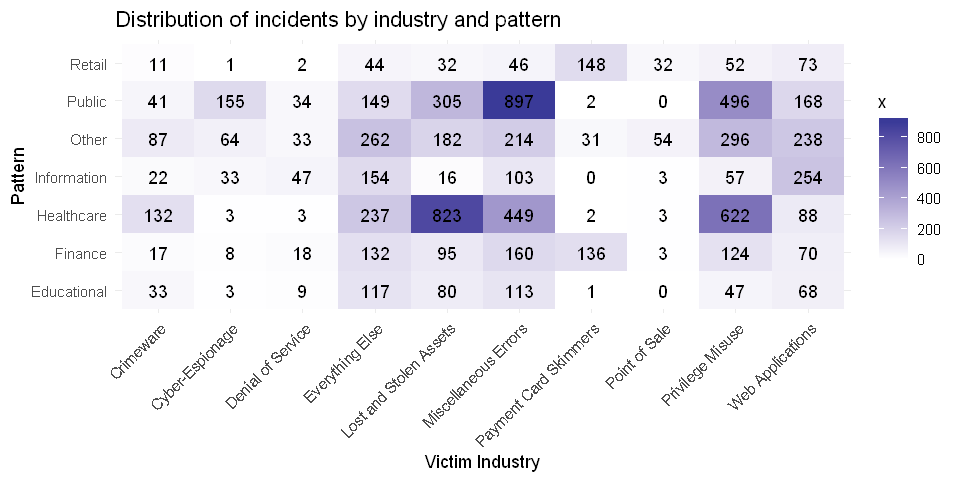

In [23]:
b <- getenum(vcdb_p, c("victim.industry2", "pattern"))
#convert NAICS to Name
n1 <- b$n[1]
b$enum <- mapping_compact(b$enum)
b <- aggregate(.~enum1+enum, b, sum)
b$n <- n1

b %>%
  dplyr::filter(!is.na(enum1)) %>%
  #dplyr::filter(!stringr::str_detect(enum, "Unknown")) %>%
  #  dplyr::mutate(by = stringr::str_sub(by, 15)) %>%
  ggplot() + geom_tile(aes(x=enum, y=enum1, fill=x)) +
  geom_text(aes(x=enum, y=enum1, label=x)) +
  scale_fill_gradient2() + coord_flip() +
  theme_minimal() + labs(title="Distribution of incidents by industry and pattern", 
                         y="Victim Industry", x="Pattern")+
  theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45)) 

## Industry - Actor
### Victim industry - External Internal Partner

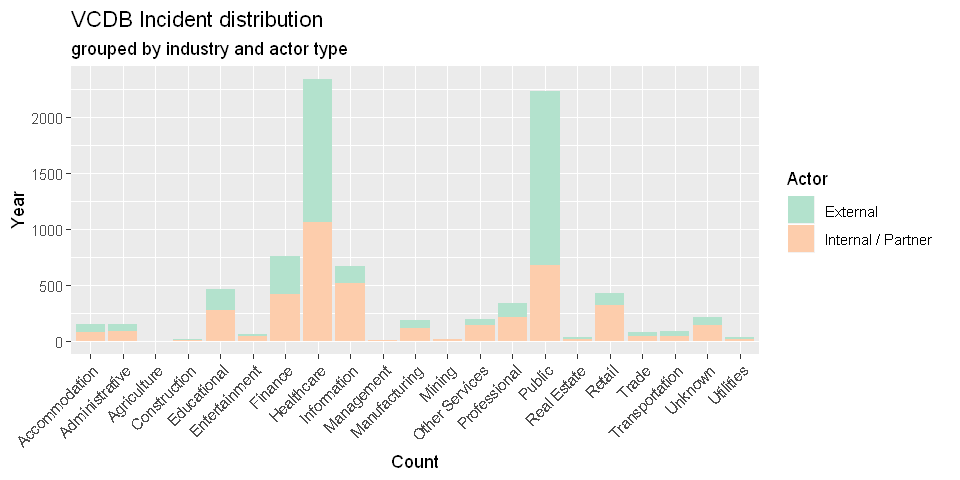

In [24]:
#need names to compact name mapping
#ind.name <- mapping_compact(ind.name)
vcdb %>%
    dplyr::group_by(actor.External) %>%
    dplyr::count(victim.industry.name) %>%
    dplyr::ungroup() %>%
    dplyr::mutate(actor=ifelse(actor.External, "External", "Internal/Partner")) %>%
  ggplot() +geom_bar(aes(x=victim.industry.name, y=n, group=actor.External, fill=actor.External), stat="identity") +
    labs(title="VCDB Incident distribution", subtitle="grouped by industry and actor type",
         x="Count", y="Year") +
    scale_fill_manual(labels=c("External", "Internal / Partner"),
                        values = brewer.pal(n = 2, name = "Pastel2")) +
    guides(fill=guide_legend(title="Actor")) +
    theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45)) 

### Victim Industry - External actor variety

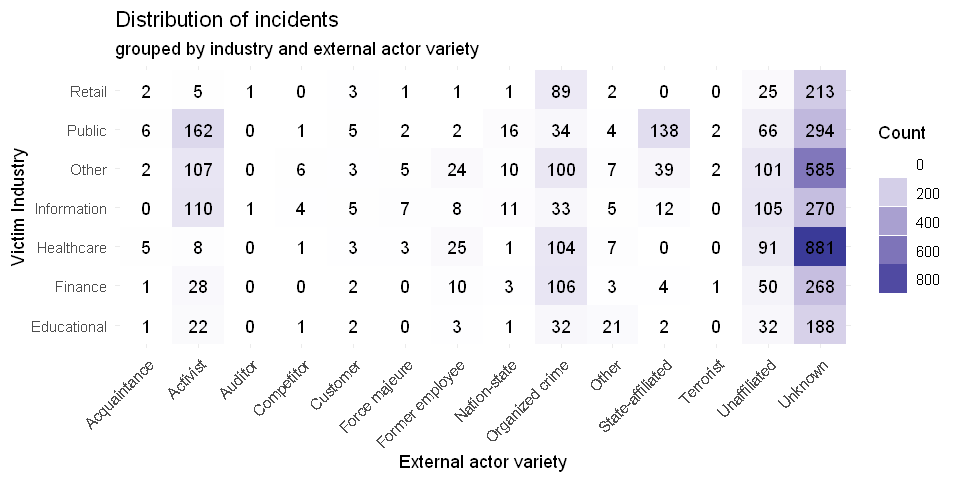

In [26]:
b <- getenum(vcdb, c("victim.industry2", "actor.external.variety"))
#convert NAICS to Name
n1 <- b$n[1]
b$enum <- mapping_compact(b$enum)
b <- aggregate(.~enum1+enum, b, sum)
b$n <- n1

b %>%
  dplyr::filter(!is.na(enum1)) %>%
  #dplyr::filter(!stringr::str_detect(enum, "Unknown")) %>%
  #  dplyr::mutate(by = stringr::str_sub(by, 15)) %>%
  ggplot() + geom_tile(aes(x=enum, y=enum1, fill=x)) +
  geom_text(aes(x=enum, y=enum1, label=x)) +
  scale_fill_gradient2() + coord_flip() +
  theme_minimal() + labs(title="Distribution of incidents",
                         subtitle="grouped by industry and external actor variety", 
                         x="Victim Industry", y="External actor variety")+
  guides(fill=guide_legend(title="Count")) + theme_minimal() +
  theme(axis.text = element_text(),
        axis.text.x = element_text(hjust=1, angle=45))

## Clustering

In [27]:
library(cluster)
library(readr)
library(Rtsne)


Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



ERROR: Error in library(Rtsne): there is no package called 'Rtsne'


In [28]:
install.packages("Rtsne")

Installing package into 'C:/Users/spele/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'Rtsne' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\spele\AppData\Local\Temp\RtmpktrfxB\downloaded_packages
